In [2]:
from IPython import display

import numpy as np
import torch
from torch import nn
from torch.optim import Adam
from torch.autograd import Variable

import cv2
#from skimage.metrics import structural_similarity as ssim
import copy


In [3]:
# define internal pic res
ires = 16
res = 128
nvars = 8
mnvars = 8*1 +1


In [4]:

class GenerativeNet(torch.nn.Module):

    def __init__(self):
        super(GenerativeNet, self).__init__()

        self.conv11 = nn.Sequential(
            #nn.BatchNorm2d(mnvars),
            nn.Conv2d(
                in_channels=mnvars, out_channels=1024, kernel_size=4,
                stride=2, padding=1, bias=True
            ),
            nn.BatchNorm2d(1024),
            nn.LeakyReLU(0.2, inplace=True)
        )
        self.conv22 = nn.Sequential(
            nn.Conv2d(
                in_channels=1024, out_channels=2048, kernel_size=4,
                stride=2, padding=1, bias=True
            ),
            nn.BatchNorm2d(2048),
            nn.LeakyReLU(0.2, inplace=True)
        )
        self.conv1 = nn.Sequential(
            nn.ConvTranspose2d(
                in_channels=2048, out_channels=1024, kernel_size=4,
                stride=2, padding=1, bias=True
            ),
            nn.BatchNorm2d(1024),
            nn.LeakyReLU(0.2, inplace=True)
        )
        self.conv2 = nn.Sequential(
            nn.ConvTranspose2d(
                in_channels=1024+1024*1, out_channels=512, kernel_size=4,
                stride=2, padding=1, bias=True
            ),
            nn.BatchNorm2d(512),
            nn.LeakyReLU(0.2, inplace=True)
        )


        self.conv3 = nn.Sequential(
            nn.ConvTranspose2d(
                in_channels=512+mnvars*1, out_channels=256, kernel_size=4,
                stride=2, padding=1, bias=True
            ),
            nn.BatchNorm2d(256),
            nn.LeakyReLU(0.2, inplace=True)
        )

        self.conv4 = nn.Sequential(
            nn.ConvTranspose2d(
                in_channels=256, out_channels=128, kernel_size=4,
                stride=2, padding=1, bias=True
            ),
            nn.BatchNorm2d(128),
            nn.LeakyReLU(0.2, inplace=True)
        )

        self.conv5 = nn.Sequential(
            nn.ConvTranspose2d(
                in_channels=128, out_channels=nvars, kernel_size=4,
                stride=2, padding=1, bias=True
            ),
            #nn.BatchNorm2d(nvars),
            #nn.LeakyReLU(0.2, inplace=True)
            nn.Sigmoid() # constrain output to 0-1 b/c SSIM does not like them
        )
        # NOT USED # smoothing 3x3 stride 1 conv
        self.conv6 = nn.Sequential(
            nn.Conv2d(
                in_channels=nvars, out_channels=nvars, kernel_size=3,
                stride=1, padding=1, bias=True
            ),
            #nn.BatchNorm2d(nvars),
            #nn.LeakyReLU(0.2, inplace=True)
            nn.Sigmoid() # constrain output to 0-1 b/c SSIM does not like them
        )

    def forward(self, x):
        # Project and reshape
        #x = self.linear(x)
        x1 = x.view(x.shape[0], mnvars, ires, ires)

        #m = nn.Dropout(p=0.1)
        #x1 = m(x1)

        # Convolutional layers
        x2 = self.conv11(x1)
        x = self.conv22(x2)
        #x = self.conv333(x)

        x = self.conv1(x)

        x = self.conv2(torch.cat((x, x2), dim=1))
        x = self.conv3(torch.cat((x, x1), dim=1))
        x = self.conv4(x)
        x = self.conv5(x)
        
        return x



In [5]:
# load generator
generator = GenerativeNet()
#gstate = torch.load("/glade/scratch/dkorytin/saved_models/uatm-erai-with-doy-cuda_generator-e850", map_location=torch.device('cuda:0'))
gstate = torch.load("/glade/scratch/dkorytin/saved_models/uatm-erai-with-doy-cuda_generator-e850", map_location=torch.device('cpu'))
minmaxo = gstate['minmaxo']
minmaxi = gstate['minmaxi']
generator.load_state_dict(gstate['generator'])
generator.eval()


GenerativeNet(
  (conv11): Sequential(
    (0): Conv2d(9, 1024, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (1): BatchNorm2d(1024, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): LeakyReLU(negative_slope=0.2, inplace=True)
  )
  (conv22): Sequential(
    (0): Conv2d(1024, 2048, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (1): BatchNorm2d(2048, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): LeakyReLU(negative_slope=0.2, inplace=True)
  )
  (conv1): Sequential(
    (0): ConvTranspose2d(2048, 1024, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (1): BatchNorm2d(1024, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): LeakyReLU(negative_slope=0.2, inplace=True)
  )
  (conv2): Sequential(
    (0): ConvTranspose2d(2048, 512, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): LeakyReLU(negative

# Load output gridmet data (to verify agaist if wanted)

In [6]:
##################
## LOAD GRIDMET ##
##################
# 1980-1989
istart = 365
#ndays = 3653  # 1980-1989
ndays = 13515 # 1980-2016 



nvars = 8
mb = 4      # minibatch size

# load files
d = np.load('/glade/work/dkorytin/srgan_data/prec128_gridmetB_1979-2016.npy')[istart:istart+ndays]
dv2 = np.load('/glade/work/dkorytin/srgan_data/tmax128_gridmetB_1979-2016.npy')[istart:istart+ndays]
dv3 = np.load('/glade/work/dkorytin/srgan_data/tmin128_gridmetB_1979-2016.npy')[istart:istart+ndays]
dv4 = np.load('/glade/work/dkorytin/srgan_data/uas128_gridmetB_1979-2016.npy')[istart:istart+ndays]
dv5 = np.load('/glade/work/dkorytin/srgan_data/vas128_gridmetB_1979-2016.npy')[istart:istart+ndays]
dv6 = np.load('/glade/work/dkorytin/srgan_data/huss128_gridmetB_1979-2016.npy')[istart:istart+ndays]
dv7 = np.load('/glade/work/dkorytin/srgan_data/rsds128_gridmetB_1979-2016.npy')[istart:istart+ndays]
dv8 = np.load('/glade/work/dkorytin/srgan_data/miss128_gridmetB_1979-2016.npy')[istart:istart+ndays]

[[v1min,v1max],[v2min,v2max],[v3min,v3max],[v4min,v4max],[v5min,v5max],[v6min,v6max],[v7min,v7max],[v8min,v8max]] = minmaxo # saved w/ model
## Find min/max for each variable
#v1max = minmaxo[0][1]; v1min = minmaxo[0][0]
#v2max = minmaxo[1][1]; v2min = minmaxo[1][0]
#v3max = minmaxo[2][1]; v3min = minmaxo[2][0]
#v4max = minmaxo[3][1]; v4min = minmaxo[3][0]
#v5max = minmaxo[4][1]; v5min = minmaxo[4][0]
#v6max = minmaxo[5][1]; v6min = minmaxo[5][0]
#v7max = minmaxo[6][1]; v7min = minmaxo[6][0]
#v8max = minmaxo[7][1]; v8min = minmaxo[7][0]
print("v1 max/min", v1max, v1min)
print("v2 max/min", v2max, v2min)
print("v3 max/min", v3max, v3min)
print("v4 max/min", v4max, v4min)
print("v5 max/min", v5max, v5min)
print("v6 max/min", v6max, v6min)
print("v7 max/min", v7max, v7min)
print("v8 max/min", v8max, v8min)
print("minmaxo", minmaxo)


# normalize each var to 0-1
d = d**0.25/(v1max)
dv2 = (dv2-v2min)/(v2max-v2min)
dv3 = (dv3-v3min)/(v3max-v3min)
dv4 = (dv4-v4min)/(v4max-v4min)
dv5 = (dv5-v5min)/(v5max-v5min)
dv6 = (dv6-v6min)/(v6max-v6min)
dv7 = (dv7-v7min)/(v7max-v7min)
dv8 = (dv8-v8min)/(v8max-v8min)

# mask & mask_bias
#mask = 1-torch.tensor(dv8[0:1,:,:]).cuda().view(1,1,res,res)
#invmask = torch.tensor(dv8[0:1,:,:]).cuda().view(1,1,res,res)
mask = 1-torch.tensor(dv8[0:1,:,:]).cpu().view(1,1,res,res)
invmask = torch.tensor(dv8[0:1,:,:]).cpu().view(1,1,res,res)
b1 = invmask*(0-v1min)/(v1max-v1min)
b2 = invmask*(0-v2min)/(v2max-v2min)
b3 = invmask*(0-v3min)/(v3max-v3min)
b4 = invmask*(0-v4min)/(v4max-v4min)
b5 = invmask*(0-v5min)/(v5max-v5min)
b6 = invmask*(0-v6min)/(v6max-v6min)
b7 = invmask*(0-v7min)/(v7max-v7min)
b8 = mask*(0-v8min)/(v8max-v8min)
mask_bias = torch.cat((b1,b2,b3,b4,b5,b6,b7,b8),1).detach()


v1 max/min 4.087455 0.0
v2 max/min 49.037712 -34.785778
v3 max/min 33.991703 -46.725536
v4 max/min 19.132183 -19.009077
v5 max/min 17.8808 -18.086332
v6 max/min 0.024878306 0.0
v7 max/min 447.97797 0.0
v8 max/min 1.0 0.0
minmaxo [[0.0, 4.087455], [-34.785778, 49.037712], [-46.725536, 33.991703], [-19.009077, 19.132183], [-18.086332, 17.8808], [0.0, 0.024878306], [0.0, 447.97797], [0.0, 1.0]]


# Load input data

In [7]:
###########################
## LOAD ERAI data: daily ##
###########################

# load eraionmpi
#mndays = 11688      # 1979-2010
mstart = 365
mndays = 13515       # 1980-2016 
#mnvars = 8*4
mnvars = 8*1
md = np.load('/glade/scratch/dkorytin/erai-on-mpigrid/U850.ERAI.MPIGRID.1979-2018.npy')[mstart:mstart+mndays*1]
mdv2 = np.load('/glade/scratch/dkorytin/erai-on-mpigrid/V850.ERAI.MPIGRID.1979-2018.npy')[mstart:mstart+mndays*1]
mdv3 = np.load('/glade/scratch/dkorytin/erai-on-mpigrid/Q850.ERAI.MPIGRID.1979-2018.npy')[mstart:mstart+mndays*1]
mdv4 = np.load('/glade/scratch/dkorytin/erai-on-mpigrid/T700.ERAI.MPIGRID.1979-2018.npy')[mstart:mstart+mndays*1]
mdv5 = np.load('/glade/scratch/dkorytin/erai-on-mpigrid/Z700.ERAI.MPIGRID.1979-2018.npy')[mstart:mstart+mndays*1]
mdv6 = np.load('/glade/scratch/dkorytin/erai-on-mpigrid/Z500.ERAI.MPIGRID.1979-2018.npy')[mstart:mstart+mndays*1]
mdv7 = np.load('/glade/scratch/dkorytin/erai-on-mpigrid/U250.ERAI.MPIGRID.1979-2018.npy')[mstart:mstart+mndays*1]
mdv8 = np.load('/glade/scratch/dkorytin/erai-on-mpigrid/V250.ERAI.MPIGRID.1979-2018.npy')[mstart:mstart+mndays*1]

print("Days loaded", len(mdv7))

[[mv1min,mv1max],[mv2min,mv2max],[mv3min,mv3max],[mv4min,mv4max],[mv5min,mv5max],[mv6min,mv6max],[mv7min,mv7max],[mv8min,mv8max]] = minmaxi # saved w/ model
## Find min/max for each variable
#mv1max = md.max(); mv1min = md.min()
#mv2max = mdv2.max(); mv2min = mdv2.min()
#mv3max = mdv3.max(); mv3min = mdv3.min()
#mv4max = mdv4.max(); mv4min = mdv4.min()
#mv5max = mdv5.max(); mv5min = mdv5.min()
#mv6max = mdv6.max(); mv6min = mdv6.min()
#mv7max = mdv7.max(); mv7min = mdv7.min()
#mv8max = mdv8.max(); mv8min = mdv8.min()
print("mv1 max/min", mv1max, mv1min)
print("mv2 max/min", mv2max, mv2min)
print("mv3 max/min", mv3max, mv3min)
print("mv4 max/min", mv4max, mv4min)
print("mv5 max/min", mv5max, mv5min)
print("mv6 max/min", mv6max, mv6min)
print("mv7 max/min", mv7max, mv7min)
print("mv8 max/min", mv8max, mv8min)

# normalize each var to 0-1
md = (md-mv1min)/(mv1max-mv1min)
mdv2 = (mdv2-mv2min)/(mv2max-mv2min)
mdv3 = (mdv3-mv3min)/(mv3max-mv3min)
mdv4 = (mdv4-mv4min)/(mv4max-mv4min)
mdv5 = (mdv5-mv5min)/(mv5max-mv5min)
mdv6 = (mdv6-mv6min)/(mv6max-mv6min)
mdv7 = (mdv7-mv7min)/(mv7max-mv7min)
mdv8 = (mdv8-mv8min)/(mv8max-mv8min)

mndays = len(mdv8)    #//4
print("mndays", mndays)

# synthetically create 16x16 input samples via bilinear scaling
dd=[]
ddo=[]
for ii in range(mndays):
    # input samples
    rowdd = []
    for iii in [0]: #range(4):
    #for iii in range(4):
       rowdd.append( cv2.resize(md[ii*1+iii],(16,16)) )
       rowdd.append( cv2.resize(mdv2[ii*1+iii],(16,16)) )
       rowdd.append( cv2.resize(mdv3[ii*1+iii],(16,16)) )
       rowdd.append( cv2.resize(mdv4[ii*1+iii],(16,16)) )
       rowdd.append( cv2.resize(mdv5[ii*1+iii],(16,16)) )
       rowdd.append( cv2.resize(mdv6[ii*1+iii],(16,16)) )
       rowdd.append( cv2.resize(mdv7[ii*1+iii],(16,16)) )
       rowdd.append( cv2.resize(mdv8[ii*1+iii],(16,16)) )
       # add doy
       rowdd.append( np.ones((16,16),dtype=np.float32)*np.cos(ii/365.25*3.14159*2.)/2. +0.5)

       dd.append(rowdd)

    # output samples
    rowddo = []
    rowddo.append( d[ii] )
    rowddo.append( dv2[ii] )
    rowddo.append( dv3[ii] )
    rowddo.append( dv4[ii] )
    rowddo.append( dv5[ii] )
    rowddo.append( dv6[ii] )
    rowddo.append( dv7[ii] )
    rowddo.append( dv8[ii] )
    ddo.append(rowddo)
    
# add channel for cos
mnvars = 9

d = np.array(dd)
do = np.array(ddo)
print("d, do, md",d.shape, do.shape, np.array(md).shape)

# input samples
samples = []
print("ndays, mndays", ndays, mndays)
for t in range(ndays):
    samples.append(d[t])
samples = torch.tensor(np.reshape(samples, (ndays, mnvars, ires, ires)))

# output samples
osamples = []    # 20x20 samples
for t in range(ndays):
    osamples.append(do[t])
osamples = torch.tensor(np.reshape(osamples, (ndays, nvars, res, res)))
print("osamples max min",osamples.max(), osamples.min())

# debug
np.save("delme.npy", samples[0,2])
#np.save("delme.npy", mdv3[0])
print("DONEDONE\n\n", mdv3[0][0].shape)

def dn(pr_img):
    #print('OioijIOJ', v1max, v1min, float(pr_img.max()), float(pr_img.min()), pr_img.shape)
    return (pr_img*(v1max-v1min)+v1min)**4
def rn(pr_img):
    #return (pr_img-v1min**4)/(v1max**4-v1min**4)
    #print('OioijIOJ222222', v1max, v1min, float(pr_img.max()), float(pr_img.min()), pr_img.shape)
    #return pr_img/v1max_orig
    return pr_img/v1max**4


Days loaded 13515
mv1 max/min 29.960123 -32.7581
mv2 max/min 30.62581 -32.324654
mv3 max/min 0.017681489 4.8779977e-05
mv4 max/min 294.80206 228.65608
mv5 max/min 3278.9453 2396.74
mv6 max/min 6005.7915 4669.179
mv7 max/min 99.96935 -43.84638
mv8 max/min 75.44277 -83.25877
mndays 13515
d, do, md (13515, 9, 16, 16) (13515, 8, 128, 128) (13515, 18, 18)
ndays, mndays 13515 13515
osamples max min tensor(1.1676) tensor(0.)
DONEDONE

 (18,)


In [8]:
##################################
## convert in batches of 1 #000 ##
##################################
downscaled_imgs = np.zeros((ndays,nvars,res,res))

#input_img = samples[0:1].cuda()
#print("input_img", input_img.shape)
#corrected_img = generator(input_img).data.cpu() 
#print("corrected_img", corrected_img.shape)

mb = 1

xplot = []
yplot = []
ymulti = []
raininput = torch.zeros(9,16,16)
dryinput = torch.zeros(9,16,16)
raincount = 0
drycount = 0
#for ii in range(0,mndays,mb):
for ii in range(0,11688,1):
    doy = ii % 365.25
    #if doy >= 0 and doy <= 30:      # Dec
    if doy >= 120 and doy <= 150:   # May
        print ("###", ii, doy)
        #input_img = samples[ii:ii+mb].cuda()
        input_img = samples[ii:ii+mb]
        generated_img = generator(input_img)#.data.cpu()
        generated_img = torch.cat((generated_img[:,0:7,:,:] * mask[:,0:1,:,:].detach(), generated_img[:,7:8,:,:]*invmask[:,0:1,:,:].detach()), 1) + mask_bias

        #mpr = dn(generated_img[:,0,:,:]).mean()
        mpr = dn(generated_img[:,0,35:60,42:75]).mean()
        print(mpr)
        if mpr > 2:
            raininput += samples[ii,:,:,:]
            raincount += 1
        if mpr < .3:
            dryinput += samples[ii,:,:,:]
            drycount += 1

        #print("generated_img", generated_img.shape)
        downscaled_imgs[ii:ii+mb] = generated_img[0:mb].data.cpu()
        #print("corrected_img", downscaled_imgs.shape)

raininput /= raincount
dryinput /= drycount


### 120 120.0
OioijIOJ 4.087455 0.0 0.5116353034973145 2.388686652921024e-07 torch.Size([1, 25, 33])
tensor(3.7198, grad_fn=<MeanBackward0>)
### 121 121.0
OioijIOJ 4.087455 0.0 0.5380396842956543 7.497354090446606e-06 torch.Size([1, 25, 33])
tensor(5.8660, grad_fn=<MeanBackward0>)
### 122 122.0
OioijIOJ 4.087455 0.0 0.5418193340301514 2.3475903887515415e-08 torch.Size([1, 25, 33])
tensor(4.7142, grad_fn=<MeanBackward0>)
### 123 123.0
OioijIOJ 4.087455 0.0 0.4290338158607483 5.5436242402118197e-11 torch.Size([1, 25, 33])
tensor(0.3968, grad_fn=<MeanBackward0>)
### 124 124.0
OioijIOJ 4.087455 0.0 0.3449617624282837 4.150573287842185e-11 torch.Size([1, 25, 33])
tensor(0.3576, grad_fn=<MeanBackward0>)
### 125 125.0
OioijIOJ 4.087455 0.0 0.4205918312072754 1.0999418234146786e-14 torch.Size([1, 25, 33])
tensor(1.0142, grad_fn=<MeanBackward0>)
### 126 126.0
OioijIOJ 4.087455 0.0 0.5527555346488953 2.7956229331493887e-08 torch.Size([1, 25, 33])
tensor(1.6969, grad_fn=<MeanBackward0>)
### 127 1

OioijIOJ 4.087455 0.0 0.6300544738769531 0.006782022770494223 torch.Size([1, 25, 33])
tensor(11.6762, grad_fn=<MeanBackward0>)
### 514 148.75
OioijIOJ 4.087455 0.0 0.6464083790779114 0.24653536081314087 torch.Size([1, 25, 33])
tensor(12.7409, grad_fn=<MeanBackward0>)
### 515 149.75
OioijIOJ 4.087455 0.0 0.5317426323890686 0.07618925720453262 torch.Size([1, 25, 33])
tensor(4.6680, grad_fn=<MeanBackward0>)
### 851 120.5
OioijIOJ 4.087455 0.0 0.45460647344589233 1.704477531339066e-11 torch.Size([1, 25, 33])
tensor(0.8773, grad_fn=<MeanBackward0>)
### 852 121.5
OioijIOJ 4.087455 0.0 0.3575122058391571 4.644814394216823e-11 torch.Size([1, 25, 33])
tensor(0.4630, grad_fn=<MeanBackward0>)
### 853 122.5
OioijIOJ 4.087455 0.0 0.4094619154930115 4.310415739616769e-12 torch.Size([1, 25, 33])
tensor(0.7850, grad_fn=<MeanBackward0>)
### 854 123.5
OioijIOJ 4.087455 0.0 0.5523232817649841 2.6101552066393197e-05 torch.Size([1, 25, 33])
tensor(4.0501, grad_fn=<MeanBackward0>)
### 855 124.5
OioijIOJ 4.0

OioijIOJ 4.087455 0.0 0.5482746958732605 2.828946662702947e-06 torch.Size([1, 25, 33])
tensor(2.0327, grad_fn=<MeanBackward0>)
### 1242 146.25
OioijIOJ 4.087455 0.0 0.5315694808959961 2.528488403186202e-05 torch.Size([1, 25, 33])
tensor(3.0671, grad_fn=<MeanBackward0>)
### 1243 147.25
OioijIOJ 4.087455 0.0 0.5186638832092285 1.2213595823595824e-07 torch.Size([1, 25, 33])
tensor(4.0007, grad_fn=<MeanBackward0>)
### 1244 148.25
OioijIOJ 4.087455 0.0 0.5117846131324768 2.2911286578164436e-05 torch.Size([1, 25, 33])
tensor(3.9539, grad_fn=<MeanBackward0>)
### 1245 149.25
OioijIOJ 4.087455 0.0 0.5962876081466675 1.0653375284164213e-05 torch.Size([1, 25, 33])
tensor(8.7577, grad_fn=<MeanBackward0>)
### 1581 120.0
OioijIOJ 4.087455 0.0 0.4027753174304962 3.4232592545001845e-18 torch.Size([1, 25, 33])
tensor(0.5093, grad_fn=<MeanBackward0>)
### 1582 121.0
OioijIOJ 4.087455 0.0 0.6452701091766357 5.612435529656068e-07 torch.Size([1, 25, 33])
tensor(6.9574, grad_fn=<MeanBackward0>)
### 1583 122.

OioijIOJ 4.087455 0.0 0.29055821895599365 2.335610303120233e-17 torch.Size([1, 25, 33])
tensor(0.0683, grad_fn=<MeanBackward0>)
### 1970 143.75
OioijIOJ 4.087455 0.0 0.4204913079738617 3.767368953582143e-17 torch.Size([1, 25, 33])
tensor(0.3501, grad_fn=<MeanBackward0>)
### 1971 144.75
OioijIOJ 4.087455 0.0 0.36848750710487366 8.704866797000499e-13 torch.Size([1, 25, 33])
tensor(0.2107, grad_fn=<MeanBackward0>)
### 1972 145.75
OioijIOJ 4.087455 0.0 0.5569998025894165 3.6162073335788136e-10 torch.Size([1, 25, 33])
tensor(3.2929, grad_fn=<MeanBackward0>)
### 1973 146.75
OioijIOJ 4.087455 0.0 0.6460666060447693 4.061607994376715e-11 torch.Size([1, 25, 33])
tensor(6.2169, grad_fn=<MeanBackward0>)
### 1974 147.75
OioijIOJ 4.087455 0.0 0.5814070105552673 1.4081819748896357e-13 torch.Size([1, 25, 33])
tensor(4.0110, grad_fn=<MeanBackward0>)
### 1975 148.75
OioijIOJ 4.087455 0.0 0.5304929614067078 1.4622224716513193e-18 torch.Size([1, 25, 33])
tensor(1.2877, grad_fn=<MeanBackward0>)
### 1976 1

OioijIOJ 4.087455 0.0 0.4861038029193878 1.987190620389434e-11 torch.Size([1, 25, 33])
tensor(2.8749, grad_fn=<MeanBackward0>)
### 2698 141.25
OioijIOJ 4.087455 0.0 0.6612639427185059 0.023737289011478424 torch.Size([1, 25, 33])
tensor(16.8522, grad_fn=<MeanBackward0>)
### 2699 142.25
OioijIOJ 4.087455 0.0 0.6539462208747864 0.22904041409492493 torch.Size([1, 25, 33])
tensor(14.8261, grad_fn=<MeanBackward0>)
### 2700 143.25
OioijIOJ 4.087455 0.0 0.5955336093902588 0.044894855469465256 torch.Size([1, 25, 33])
tensor(10.4348, grad_fn=<MeanBackward0>)
### 2701 144.25
OioijIOJ 4.087455 0.0 0.5408638715744019 2.2784736302128294e-06 torch.Size([1, 25, 33])
tensor(6.2470, grad_fn=<MeanBackward0>)
### 2702 145.25
OioijIOJ 4.087455 0.0 0.7136238217353821 2.5026994990184903e-05 torch.Size([1, 25, 33])
tensor(15.2737, grad_fn=<MeanBackward0>)
### 2703 146.25
OioijIOJ 4.087455 0.0 0.7757031917572021 3.595201576445106e-07 torch.Size([1, 25, 33])
tensor(26.9891, grad_fn=<MeanBackward0>)
### 2704 147

OioijIOJ 4.087455 0.0 0.6242077350616455 2.5835214281349486e-16 torch.Size([1, 25, 33])
tensor(9.7975, grad_fn=<MeanBackward0>)
### 3426 138.75
OioijIOJ 4.087455 0.0 0.40107542276382446 4.063673226042952e-13 torch.Size([1, 25, 33])
tensor(0.2972, grad_fn=<MeanBackward0>)
### 3427 139.75
OioijIOJ 4.087455 0.0 0.6227409839630127 1.3815116856486648e-13 torch.Size([1, 25, 33])
tensor(2.3354, grad_fn=<MeanBackward0>)
### 3428 140.75
OioijIOJ 4.087455 0.0 0.5273957848548889 2.3207884838578137e-16 torch.Size([1, 25, 33])
tensor(2.4595, grad_fn=<MeanBackward0>)
### 3429 141.75
OioijIOJ 4.087455 0.0 0.6523520350456238 4.955486975627421e-13 torch.Size([1, 25, 33])
tensor(9.0738, grad_fn=<MeanBackward0>)
### 3430 142.75
OioijIOJ 4.087455 0.0 0.3671947717666626 1.9752075241152409e-19 torch.Size([1, 25, 33])
tensor(0.1009, grad_fn=<MeanBackward0>)
### 3431 143.75
OioijIOJ 4.087455 0.0 0.29055869579315186 2.9458176403874047e-24 torch.Size([1, 25, 33])
tensor(0.0224, grad_fn=<MeanBackward0>)
### 3432

OioijIOJ 4.087455 0.0 0.522933304309845 2.7072611513689893e-11 torch.Size([1, 25, 33])
tensor(1.9910, grad_fn=<MeanBackward0>)
### 4154 136.25
OioijIOJ 4.087455 0.0 0.5392572283744812 1.8868651622703722e-14 torch.Size([1, 25, 33])
tensor(0.7980, grad_fn=<MeanBackward0>)
### 4155 137.25
OioijIOJ 4.087455 0.0 0.4921731948852539 2.2959073336069336e-13 torch.Size([1, 25, 33])
tensor(1.2624, grad_fn=<MeanBackward0>)
### 4156 138.25
OioijIOJ 4.087455 0.0 0.518036425113678 7.07781948335555e-16 torch.Size([1, 25, 33])
tensor(2.5473, grad_fn=<MeanBackward0>)
### 4157 139.25
OioijIOJ 4.087455 0.0 0.5880720019340515 2.31043049275792e-13 torch.Size([1, 25, 33])
tensor(4.9746, grad_fn=<MeanBackward0>)
### 4158 140.25
OioijIOJ 4.087455 0.0 0.5928632616996765 6.096504052456597e-13 torch.Size([1, 25, 33])
tensor(3.8837, grad_fn=<MeanBackward0>)
### 4159 141.25
OioijIOJ 4.087455 0.0 0.5671274065971375 3.3503519603073073e-07 torch.Size([1, 25, 33])
tensor(6.6114, grad_fn=<MeanBackward0>)
### 4160 142.25

OioijIOJ 4.087455 0.0 0.2682439088821411 1.2278966797757662e-16 torch.Size([1, 25, 33])
tensor(0.0207, grad_fn=<MeanBackward0>)
### 4882 133.75
OioijIOJ 4.087455 0.0 0.41108718514442444 6.541807460319626e-12 torch.Size([1, 25, 33])
tensor(0.3271, grad_fn=<MeanBackward0>)
### 4883 134.75
OioijIOJ 4.087455 0.0 0.40194782614707947 7.69362490382619e-11 torch.Size([1, 25, 33])
tensor(0.6222, grad_fn=<MeanBackward0>)
### 4884 135.75
OioijIOJ 4.087455 0.0 0.47723811864852905 1.3527970410542878e-10 torch.Size([1, 25, 33])
tensor(2.6148, grad_fn=<MeanBackward0>)
### 4885 136.75
OioijIOJ 4.087455 0.0 0.6245665550231934 0.00011886196443811059 torch.Size([1, 25, 33])
tensor(8.3407, grad_fn=<MeanBackward0>)
### 4886 137.75
OioijIOJ 4.087455 0.0 0.5889871716499329 0.00038174507790245116 torch.Size([1, 25, 33])
tensor(4.6760, grad_fn=<MeanBackward0>)
### 4887 138.75
OioijIOJ 4.087455 0.0 0.3923332691192627 9.085376223051667e-13 torch.Size([1, 25, 33])
tensor(0.7749, grad_fn=<MeanBackward0>)
### 4888 

OioijIOJ 4.087455 0.0 0.4493839144706726 6.576009702052854e-12 torch.Size([1, 25, 33])
tensor(0.6280, grad_fn=<MeanBackward0>)
### 5610 131.25
OioijIOJ 4.087455 0.0 0.3631586730480194 2.2365512220012818e-12 torch.Size([1, 25, 33])
tensor(0.1687, grad_fn=<MeanBackward0>)
### 5611 132.25
OioijIOJ 4.087455 0.0 0.5250000953674316 1.617265484943689e-13 torch.Size([1, 25, 33])
tensor(0.2737, grad_fn=<MeanBackward0>)
### 5612 133.25
OioijIOJ 4.087455 0.0 0.40495699644088745 4.939795033829001e-16 torch.Size([1, 25, 33])
tensor(0.1684, grad_fn=<MeanBackward0>)
### 5613 134.25
OioijIOJ 4.087455 0.0 0.5981019735336304 4.866479567683813e-15 torch.Size([1, 25, 33])
tensor(2.6246, grad_fn=<MeanBackward0>)
### 5614 135.25
OioijIOJ 4.087455 0.0 0.6319999694824219 8.309661847505367e-10 torch.Size([1, 25, 33])
tensor(1.4217, grad_fn=<MeanBackward0>)
### 5615 136.25
OioijIOJ 4.087455 0.0 0.7624939680099487 1.9420778318846033e-09 torch.Size([1, 25, 33])
tensor(13.0404, grad_fn=<MeanBackward0>)
### 5616 13

OioijIOJ 4.087455 0.0 0.6144253611564636 1.3947473176401104e-09 torch.Size([1, 25, 33])
tensor(9.9082, grad_fn=<MeanBackward0>)
### 6338 128.75
OioijIOJ 4.087455 0.0 0.6968629956245422 2.0609969938389174e-16 torch.Size([1, 25, 33])
tensor(4.7433, grad_fn=<MeanBackward0>)
### 6339 129.75
OioijIOJ 4.087455 0.0 0.28752273321151733 4.0915393902801744e-13 torch.Size([1, 25, 33])
tensor(0.0727, grad_fn=<MeanBackward0>)
### 6340 130.75
OioijIOJ 4.087455 0.0 0.47198858857154846 1.8973664653310074e-11 torch.Size([1, 25, 33])
tensor(0.8711, grad_fn=<MeanBackward0>)
### 6341 131.75
OioijIOJ 4.087455 0.0 0.48235633969306946 2.489864425747612e-10 torch.Size([1, 25, 33])
tensor(1.1290, grad_fn=<MeanBackward0>)
### 6342 132.75
OioijIOJ 4.087455 0.0 0.46184036135673523 9.825071935502458e-14 torch.Size([1, 25, 33])
tensor(0.6941, grad_fn=<MeanBackward0>)
### 6343 133.75
OioijIOJ 4.087455 0.0 0.4149335026741028 1.6636528309479925e-12 torch.Size([1, 25, 33])
tensor(0.9267, grad_fn=<MeanBackward0>)
### 63

OioijIOJ 4.087455 0.0 0.23772436380386353 5.0012939266218607e-20 torch.Size([1, 25, 33])
tensor(0.0165, grad_fn=<MeanBackward0>)
### 7066 126.25
OioijIOJ 4.087455 0.0 0.3147912621498108 4.0071147637033885e-18 torch.Size([1, 25, 33])
tensor(0.0227, grad_fn=<MeanBackward0>)
### 7067 127.25
OioijIOJ 4.087455 0.0 0.0050317165441811085 4.4180153267820636e-16 torch.Size([1, 25, 33])
tensor(2.8846e-10, grad_fn=<MeanBackward0>)
### 7068 128.25
OioijIOJ 4.087455 0.0 0.5932666063308716 9.955107918568906e-12 torch.Size([1, 25, 33])
tensor(5.9196, grad_fn=<MeanBackward0>)
### 7069 129.25
OioijIOJ 4.087455 0.0 0.6562419533729553 3.3486240547748927e-15 torch.Size([1, 25, 33])
tensor(8.7164, grad_fn=<MeanBackward0>)
### 7070 130.25
OioijIOJ 4.087455 0.0 0.5585289597511292 6.100839505893824e-14 torch.Size([1, 25, 33])
tensor(3.7352, grad_fn=<MeanBackward0>)
### 7071 131.25
OioijIOJ 4.087455 0.0 0.564296543598175 2.1974699827710197e-17 torch.Size([1, 25, 33])
tensor(2.3690, grad_fn=<MeanBackward0>)
###

OioijIOJ 4.087455 0.0 0.6395018100738525 4.594059213468049e-17 torch.Size([1, 25, 33])
tensor(4.7154, grad_fn=<MeanBackward0>)
### 7794 123.75
OioijIOJ 4.087455 0.0 0.7586363554000854 1.4618891555073787e-06 torch.Size([1, 25, 33])
tensor(22.6936, grad_fn=<MeanBackward0>)
### 7795 124.75
OioijIOJ 4.087455 0.0 0.7138472199440002 2.324243242313173e-09 torch.Size([1, 25, 33])
tensor(5.8599, grad_fn=<MeanBackward0>)
### 7796 125.75
OioijIOJ 4.087455 0.0 0.637266218662262 1.5615349291397962e-11 torch.Size([1, 25, 33])
tensor(6.4174, grad_fn=<MeanBackward0>)
### 7797 126.75
OioijIOJ 4.087455 0.0 0.5595918893814087 5.513082395117164e-13 torch.Size([1, 25, 33])
tensor(2.2434, grad_fn=<MeanBackward0>)
### 7798 127.75
OioijIOJ 4.087455 0.0 0.40848174691200256 8.513320629780895e-15 torch.Size([1, 25, 33])
tensor(0.1663, grad_fn=<MeanBackward0>)
### 7799 128.75
OioijIOJ 4.087455 0.0 0.4438542425632477 2.694098633418407e-12 torch.Size([1, 25, 33])
tensor(0.7928, grad_fn=<MeanBackward0>)
### 7800 129

OioijIOJ 4.087455 0.0 0.5857241153717041 4.476885175407422e-16 torch.Size([1, 25, 33])
tensor(3.5011, grad_fn=<MeanBackward0>)
### 8522 121.25
OioijIOJ 4.087455 0.0 0.4648495018482208 2.022339950667404e-13 torch.Size([1, 25, 33])
tensor(0.6600, grad_fn=<MeanBackward0>)
### 8523 122.25
OioijIOJ 4.087455 0.0 0.40674516558647156 1.7593571793164323e-16 torch.Size([1, 25, 33])
tensor(0.5204, grad_fn=<MeanBackward0>)
### 8524 123.25
OioijIOJ 4.087455 0.0 0.5350682735443115 2.102232860582082e-15 torch.Size([1, 25, 33])
tensor(1.0129, grad_fn=<MeanBackward0>)
### 8525 124.25
OioijIOJ 4.087455 0.0 0.5353341102600098 1.0174185876781782e-16 torch.Size([1, 25, 33])
tensor(0.6084, grad_fn=<MeanBackward0>)
### 8526 125.25
OioijIOJ 4.087455 0.0 0.5543093681335449 2.5083383602201833e-15 torch.Size([1, 25, 33])
tensor(2.7327, grad_fn=<MeanBackward0>)
### 8527 126.25
OioijIOJ 4.087455 0.0 0.5655611157417297 1.968986605704881e-11 torch.Size([1, 25, 33])
tensor(1.7775, grad_fn=<MeanBackward0>)
### 8528 12

OioijIOJ 4.087455 0.0 0.662082314491272 5.818509194420451e-14 torch.Size([1, 25, 33])
tensor(3.1378, grad_fn=<MeanBackward0>)
### 8915 149.0
OioijIOJ 4.087455 0.0 0.5156654715538025 6.816874010207694e-19 torch.Size([1, 25, 33])
tensor(0.7125, grad_fn=<MeanBackward0>)
### 8916 150.0
OioijIOJ 4.087455 0.0 0.5360141396522522 1.8025335712447964e-19 torch.Size([1, 25, 33])
tensor(2.4164, grad_fn=<MeanBackward0>)
### 9252 120.75
OioijIOJ 4.087455 0.0 0.47046366333961487 1.4032284499811273e-15 torch.Size([1, 25, 33])
tensor(0.9023, grad_fn=<MeanBackward0>)
### 9253 121.75
OioijIOJ 4.087455 0.0 0.5889994502067566 8.501386985874937e-13 torch.Size([1, 25, 33])
tensor(3.6917, grad_fn=<MeanBackward0>)
### 9254 122.75
OioijIOJ 4.087455 0.0 0.5243487358093262 6.312821793086343e-11 torch.Size([1, 25, 33])
tensor(2.2847, grad_fn=<MeanBackward0>)
### 9255 123.75
OioijIOJ 4.087455 0.0 0.5258681774139404 2.608332820563941e-12 torch.Size([1, 25, 33])
tensor(2.0716, grad_fn=<MeanBackward0>)
### 9256 124.75

OioijIOJ 4.087455 0.0 0.5656281113624573 5.113633131742231e-19 torch.Size([1, 25, 33])
tensor(1.3951, grad_fn=<MeanBackward0>)
### 9643 146.5
OioijIOJ 4.087455 0.0 0.41935768723487854 1.2497838050920529e-12 torch.Size([1, 25, 33])
tensor(0.2837, grad_fn=<MeanBackward0>)
### 9644 147.5
OioijIOJ 4.087455 0.0 0.3494165539741516 1.0384113562899777e-17 torch.Size([1, 25, 33])
tensor(0.1512, grad_fn=<MeanBackward0>)
### 9645 148.5
OioijIOJ 4.087455 0.0 0.5326646566390991 4.6975205843236e-12 torch.Size([1, 25, 33])
tensor(2.2031, grad_fn=<MeanBackward0>)
### 9646 149.5
OioijIOJ 4.087455 0.0 0.6148999929428101 3.0516843392558446e-12 torch.Size([1, 25, 33])
tensor(7.9963, grad_fn=<MeanBackward0>)
### 9982 120.25
OioijIOJ 4.087455 0.0 0.6418838500976562 0.009244273416697979 torch.Size([1, 25, 33])
tensor(12.1383, grad_fn=<MeanBackward0>)
### 9983 121.25
OioijIOJ 4.087455 0.0 0.6378071904182434 4.599324740506283e-11 torch.Size([1, 25, 33])
tensor(9.6972, grad_fn=<MeanBackward0>)
### 9984 122.25
O

OioijIOJ 4.087455 0.0 0.5561686754226685 1.003572080532408e-17 torch.Size([1, 25, 33])
tensor(1.9902, grad_fn=<MeanBackward0>)
### 10371 144.0
OioijIOJ 4.087455 0.0 0.6534425616264343 2.5771063817572708e-14 torch.Size([1, 25, 33])
tensor(6.0163, grad_fn=<MeanBackward0>)
### 10372 145.0
OioijIOJ 4.087455 0.0 0.6096922755241394 1.4244193324852716e-10 torch.Size([1, 25, 33])
tensor(3.6831, grad_fn=<MeanBackward0>)
### 10373 146.0
OioijIOJ 4.087455 0.0 0.7520430088043213 5.603100076197621e-15 torch.Size([1, 25, 33])
tensor(10.8295, grad_fn=<MeanBackward0>)
### 10374 147.0
OioijIOJ 4.087455 0.0 0.698585033416748 1.1797588080064703e-11 torch.Size([1, 25, 33])
tensor(18.4341, grad_fn=<MeanBackward0>)
### 10375 148.0
OioijIOJ 4.087455 0.0 0.4454284608364105 7.430552007026137e-11 torch.Size([1, 25, 33])
tensor(0.6947, grad_fn=<MeanBackward0>)
### 10376 149.0
OioijIOJ 4.087455 0.0 0.3954848349094391 2.2194326206510376e-17 torch.Size([1, 25, 33])
tensor(0.0740, grad_fn=<MeanBackward0>)
### 10377 

OioijIOJ 4.087455 0.0 0.3399665653705597 2.7495792728288388e-15 torch.Size([1, 25, 33])
tensor(0.0465, grad_fn=<MeanBackward0>)
### 11099 141.5
OioijIOJ 4.087455 0.0 0.16355103254318237 4.8935045509126556e-17 torch.Size([1, 25, 33])
tensor(0.0005, grad_fn=<MeanBackward0>)
### 11100 142.5
OioijIOJ 4.087455 0.0 0.3886632025241852 1.1374341400354357e-18 torch.Size([1, 25, 33])
tensor(0.0824, grad_fn=<MeanBackward0>)
### 11101 143.5
OioijIOJ 4.087455 0.0 0.7168895602226257 6.477485919604425e-14 torch.Size([1, 25, 33])
tensor(6.3098, grad_fn=<MeanBackward0>)
### 11102 144.5
OioijIOJ 4.087455 0.0 0.5824708938598633 1.7659754341921123e-14 torch.Size([1, 25, 33])
tensor(1.9991, grad_fn=<MeanBackward0>)
### 11103 145.5
OioijIOJ 4.087455 0.0 0.5529381632804871 4.005765052994548e-09 torch.Size([1, 25, 33])
tensor(2.5027, grad_fn=<MeanBackward0>)
### 11104 146.5
OioijIOJ 4.087455 0.0 0.40843257308006287 2.912362191687112e-14 torch.Size([1, 25, 33])
tensor(0.1973, grad_fn=<MeanBackward0>)
### 11105

# Plots

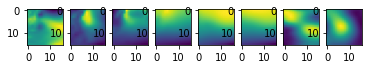

In [24]:
# plot average rain inputs
import matplotlib.pyplot as plt
f, axarr = plt.subplots(1, 8)
for ii in range(8):
    axarr[ii].imshow(raininput[ii])

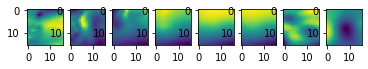

In [25]:
# plot average dry inputs
import matplotlib.pyplot as plt
f, axarr = plt.subplots(1, 8)
for ii in range(8):
    axarr[ii].imshow(dryinput[ii])

In [30]:
# what about the cos() channel
print(raininput[8].mean(), dryinput[8].mean())

tensor(0.1578) tensor(0.1664)
